# Programming your solver

TODO: A little more gentle introduction to cover the objects a little.

In this notebook, we will look at some of the more advanced capabilities Firedrake has for configuring and developing preconditioners.

As our prototypical example, we will consider the Stokes equations. Find $(u, p) \in V \times Q \subset (H^1)^d \times L^2$ such that

$$
\begin{align}
  \nu\int_\Omega \nabla u : \nabla v\,\mathrm{d}x - \int_\Omega p
  \nabla \cdot v\,\mathrm{d}x
  &= \int_\Omega f \cdot v\,\mathrm{d}x, \\
  -\int_\Omega \nabla \cdot u q \,\mathrm{d}x&= 0.
\end{align}
$$
for all $(v, q) \in V \times Q$. Where $\nu$ is the viscosity, and we have not yet introduced boundary conditions.

We're going to need a domain to solve this problem on, along with appropriate finite elements for the velocity and pressure spaces. Here we'll use the Taylor-Hood pair, although other options are available.

We start by importing functionality from the Firedrake interface, defining a mesh, and building the function spaces on it.

This is a mesh/this a function space, etc..

In [1]:
from firedrake import *

mesh = UnitSquareMesh(64, 64)

V = VectorFunctionSpace(mesh, "CG", 2)
Q = FunctionSpace(mesh, "CG", 1)
W = V*Q

## The variational problem

We will choose a viscosity that does not depend on the solution, and hence solve a linear set of equations. We will nonetheless write the problem in residual form (such that nonlinear solvers are straightforwardly available). We therefore need a `Function` to hold the discrete solution, along with some test functions to build a symbolic representation of the problem.

We also need to choose some boundary conditions, such that the problem is well-posed. In this example, we'll solve a regularised lid-driven cavity problem. For which the boundary conditions are:

$$
\begin{align}
u &= \begin{pmatrix}\frac{x^2 (2 - x)^2 y^2}{4} \\ 0 \end{pmatrix} & \text{ on $\Gamma_1 = \{y = 1\}$}\\
u &= 0 & \text{ otherwise}\\
\nabla p \cdot n &= 0 & \text{ on $\Gamma = \partial\Omega$}
\end{align}
$$

In [2]:
v, q = TestFunctions(W)

w = Function(W)
u, p = split(w)

nu = Constant(0.0001)

F = nu*inner(grad(u), grad(v))*dx - p*div(v)*dx - div(u)*q*dx

x, y = SpatialCoordinate(mesh)
forcing = as_vector([0.25 * x**2 * (2-x)**2 *y**2, 0])

bcs = [DirichletBC(W.sub(0), forcing, 4),
       DirichletBC(W.sub(0), zero(mesh.geometric_dimension()), (1, 2, 3))]

The appropriate parts of the boundary on which to apply Dirichlet conditions are selected with mesh markers. For builtin meshes, you can determine which markers are available from the constructor documentation. For external meshes, Firedrake picks up the markers in the mesh file via PETSc's DMPlex readers.

In [7]:
UnitSquareMesh?

Now we're actually going to do some numerics, not just symbolics. So we need to set up everything ready for the solver...

Finally, since we apply no Dirichlet condition on the pressure, we must construct and inform the solver that the space of constant pressures is a null mode of the operator, and should thus be projected out of the solution. We do this by constructing a basis object that describes the null space:

In [10]:
nullspace = MixedVectorSpaceBasis(W, [W.sub(0), VectorSpaceBasis(constant=True)])

## Configuring the solver

Now that the problem is set up we can try and solve it. To configure the solver, we must program it using PETSc's options system. First, a simple example, then some discussion on what it all means.

In [11]:
solver_parameters = {
    # Build an AIJ matrix (we will see others later)
    "mat_type": "aij",
    # Since the problem is linear, use a "linear only" nonlinear solver
    "snes_type": "ksponly",
    # GMRES for the linear solver
    "ksp_type": "gmres",
    # Turn on some monitors
    "ksp_monitor_true_residual": True,
    "ksp_max_it": 1500,
    "ksp_converged_reason": True,
    "ksp_rtol": 1e-7,
    # Pick a (not very strong) preconditioner
    "pc_type": "ilu",   
}

In [12]:
w.assign(0)
solve(F == 0, w, bcs=bcs, nullspace=nullspace, solver_parameters=solver_parameters)

We can now have a look at the solution, using some simple builtin plotting that utilises matplotlib. For any more complicated visualisation, save the data to a VTU file and inspect it using something like Paraview or Visit.

<IPython.core.display.Javascript object>


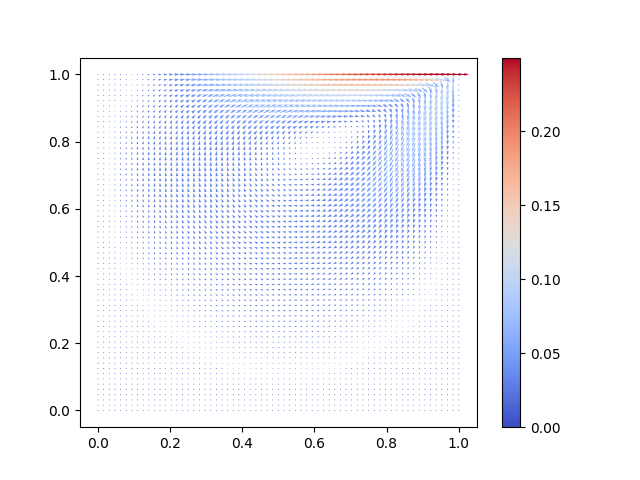

In [13]:
%matplotlib notebook
u_h, p_h = w.split()
plot(u_h);

## Configuring a better preconditioner

If we look in the stdout log (FIXME: does this work on Azure), we see that for this tiny problem, the linear solver took over 900 iterations to converge. We'd like to do rather better than this. Fortunately, there a number of known-good approaches to preconditioning Stokes' equation. We will show how to access some of them in Firedrake.

### Programming with options

Firedrake relies on PETSc to do the heavy lifting for algebraic solves. If you don't provide any parameters, we just inherit the defaults from PETSc. Of course, we can change this, and probably want to so that we pick an appropriate solver for our problem. We already saw an example of this above, setting tolerances and the like. If you're familiar with PETSc options, this will already make sense, if not, a little explanation is in order. So we'll take a brief detour to discuss the "programming language" PETSc exposes through its options database.

TODO: concrete thing
PETSc objects (such as solvers) are configurable at runtime, and the primary mechanism for doing so is through PETSc's _options database_. A PETSc object examines the database, and configures itself, when `setFromOptions` is called on it. For the solvers in Firedrake, this is arranged to happen when you call `solve`. The "programming language" for the options consists of two operations:

1. Value assignment -foo_type bar (equivalently in dict syntax `{"foo_type": "bar"}`)
2. String concatenation

The former says "set the `foo_type` key in the database to value `bar`", the latter is used, in combination with object _prefixes_ to configure multiple objects _of the same type_ in different ways.

Configuring the solver is done by providing _options_ to the solver in the form of a dictionary of solver parameters. These are passed, essentially unmodified, to PETSc which uses them to set up the solver.

## A block preconditioner for Stokes

Rather than using a monolithic ILU preconditioner, which does not perform well, we will now consider a block preconditioner using the approach of Silvester & Wathen (1994). This is accessed using PETSc's `fieldsplit` PC. This block approach exploits that the system we are trying to solve is conceptually a $2 \times 2$ block matrix:
$$
\mathcal{A} := \begin{bmatrix} A & B \\ C & 0 \end{bmatrix}
$$
which admits a factorisation
$$
   \begin{bmatrix} I & 0 \\ C A^{-1} & I\end{bmatrix}
   \begin{bmatrix}A & 0 \\ 0 & S\end{bmatrix}
   \begin{bmatrix} I & A^{-1} B \\ 0 & I\end{bmatrix},
$$
where $S := -C A^{-1} B$ is the _Schur complement_. The inverse is therefore
$$
   \mathcal{A}^{-1} =\begin{bmatrix} I & -A^{-1}B \\ 0 & I \end{bmatrix}
   \begin{bmatrix} A^{-1} & 0 \\ 0 & S^{-1}\end{bmatrix}
   \begin{bmatrix} I & 0 \\ -CA^{-1} & I\end{bmatrix}.
$$

Let's see how to set this up with solver parameters. We'll start by just setting up the block factorisation and using exact solvers for the inner blocks where possible.

In [14]:
solver_parameters = {
    "mat_type": "nest", # We only need the blocks
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "ksp_rtol": 1e-7,
    "ksp_monitor_true_residual": True,
    "ksp_max_it": 1500,
    "ksp_converged_reason": True,
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "schur",
    "fieldsplit_0": {
        "ksp_type": "preonly",
        "pc_type": "lu",
    },
    "fieldsplit_1": {
        "ksp_type": "richardson",
        "ksp_rtol": 1e-8,
        "ksp_richardson_self_scale": True,
        "ksp_converged_reason": True,
        "pc_type": "none",
    }
}

In [19]:
w.assign(0)
solve(F == 0, w, bcs=bcs, nullspace=nullspace, solver_parameters=solver_parameters)

ConvergenceError: Nonlinear solve failed to converge after 0 nonlinear iterations.
Reason:
   Inner linear solve failed to converge after 0 iterations with reason: DIVERGED_PCSETUP_FAILED

This has good outer convergence, taking just a single GMRES iteration. However, it's rather slow. The reason for this is that the Schur complement solver `fieldsplit_1` is somewhat slow to converge since we don't have a preconditioner at all. The game in speeding this solve up is to find a fast way of approximating $S^{-1}$. Either by finding a good sparse approximation to $S$ and inverting that, or else by finding a fast way of applying $S^{-1}$.

For the Stokes problem, Silvester & Wathen (1994) show that $S \approx \nu^{-1} Q$ is a good approximation, where $Q$ is the pressure mass matrix. This is good news, but we need to find a way of getting that matrix into the preconditioner.

### A separate `pmat`

One approach is that PETSc's KSP objects accept two operators, `A` which defines the operator to invert, and `P`, which is used to build the preconditioner. Firedrake supports this method of building problems, so we can just provide a separate variational form describing the preconditioning matrix `P`. To do that, we will additionally need some symbolic trial functions.

In [16]:
u_t, p_t = TrialFunctions(W)

# FIXME: want to do P = lhs(replace(F, {u: u_t, p: p_t})) + p_t * q*dx,
# but can't replace non-terminals yet
P = nu*inner(grad(u_t), grad(v))*dx - p_t*div(v)*dx - div(u_t)*q*dx + 1/nu * p_t * q*dx

We now solve the same problem, but pass an extra `Jp` argument to the solve call, which is a bilinear form used to assemble the preconditioning matrix.

In [17]:
solver_parameters = {
    "mat_type": "nest", # We only need the blocks
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "ksp_rtol": 1e-7,
    "ksp_monitor_true_residual": True,
    "ksp_max_it": 1500,
    "ksp_converged_reason": True,
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "schur",
    "fieldsplit_0": {
        "ksp_type": "preonly",
        "pc_type": "lu",
    },
    "fieldsplit_1": {
        "ksp_type": "preonly",
        "pc_type": "lu",
    }
}

In [20]:
w.assign(0)
solve(F == 0, w, bcs=bcs, nullspace=nullspace, Jp=P, solver_parameters=solver_parameters)

This works pretty well, taking only 18 outer iterations. One could also replace the inner solvers with approximate versions. We will do this momentarily when solving larger problems.

### Providing auxiliary operators
One thing that is somewhat inconvenient is that we have to build a whole new operator just to get the pressure mass matrix in to the inner preconditioner. The approach adopted in Firedrake to avoid this is to piggyback on PETSc's (and petsc4py's) support for user-defined preconditioner objects. We can define a preconditioner as a Python class, and as long as it provides certain methods, it can be used as a preconditioner by PETSc. 

As a simple example, let us write our own version of the `none` PC, which applies the identity as the preconditioner.

In [21]:
class NonePC(object):
    def apply(self, pc, x, y):
        x.copy(y)
    def applyTranspose(self, pc, x, y):
        x.copy(y)

Let's use it in place of the builtin `none` we used before, we have to provide the full name of the class used to construct the PC as an absolute path to an object in an importable Python module. For preconditioners we define in this notebook, the relevant module is the `__main__` one.

In [22]:
solver_parameters = {
    "mat_type": "nest", # We only need the blocks
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "ksp_rtol": 1e-7,
    "ksp_monitor_true_residual": True,
    "ksp_max_it": 1500,
    "ksp_converged_reason": True,
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "schur",
    "fieldsplit_0": {
        "ksp_type": "preonly",
        "pc_type": "lu",
    },
    "fieldsplit_1": {
        "ksp_type": "richardson",
        "ksp_rtol": 1e-8,
        "ksp_richardson_self_scale": True,
        "ksp_converged_reason": True,
        "pc_type": "python",
        "pc_python_type": "__main__.NonePC",
    }
}

In [23]:
w.assign(0)
solve(F == 0, w, bcs=bcs, nullspace=nullspace, solver_parameters=solver_parameters)

To simplify the problem of which methods you need to remember to implement, Firedrake offers some builtin Python preconditioners, along with an abstract base class to inherit from `PCBase`. One thing that is slightly tricky is figuring out how to get all the necessary information to construct things. For our use case, Firedrake offers a further abstraction.

Since needing to assemble an auxiliary operator of some kind is so common, we can inherit from the builtin `AuxiliaryOperatorPC` and implement the `form` method. This receives test and trial functions on the correct space and should return a form and any boundary conditions (or `None`). When it is constructed and setup, the specified operator is assembled and supplied to an algebraic preconditioner. Let's have a go:

In [24]:
class MassMatrix(AuxiliaryOperatorPC):
    # The default prefix is "aux_"
    _prefix = "mass_"
    def form(self, pc, test, trial):
        return (1/nu * test*trial*dx, None)

We use this in the same way as our `NonePC` above, but also configure the inner algebraic PC.

In [25]:
solver_parameters = {
    "mat_type": "nest", # We only need the blocks
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "ksp_rtol": 1e-7,
    "ksp_monitor_true_residual": True,
    "ksp_max_it": 1500,
    "ksp_view": True,
    "ksp_converged_reason": True,
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "schur",
    "fieldsplit_0": {
        "ksp_type": "preonly",
        "pc_type": "lu",
    },
    "fieldsplit_1": {
        "ksp_type": "preonly",
        "pc_type": "python",
        "pc_python_type": "__main__.MassMatrix",
        "mass_pc_type": "lu",
    }
}

In [26]:
w.assign(0)
solve(F == 0, w, bcs=bcs, nullspace=nullspace, solver_parameters=solver_parameters)

TODO: Discuss how to pass user data in (nu in scope is ugly).

## Multigrid preconditioners and smoothers

TODO